Author: Thibeau Wouters

##### Imports:

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy.integrate as integrate

I will create a dataframe later on, so I'll import pandas.

In [2]:
import pandas as pd

##### Configure matplotlib settings

In [3]:
plt.style.use('ggplot')
plt.rcParams.update(
    {"text.usetex": True,
     'font.serif': 'Modern Roman',
     "figure.figsize": (10, 4),
    "axes.titlesize" : 26,
    "axes.labelsize" : 28,
    "lines.linewidth": 3,
    "lines.markersize" : 10,
    "xtick.labelsize" : 24,
    "ytick.labelsize" : 24})

##### Functions:

In [4]:
def random_spins(N):
    '''Generate a N x N random lattice of spins, represented as a vector of length N^2, of random spins.'''
    spins = [-1, 1]
    
    lattice = []
    for i in range(N**2):
        lattice.append(random.choice(spins))
    
    return lattice

In [5]:
def compute_energy(lattice, N):
    '''Given a lattice, computes the energy according to Hamiltonian for the Ising model.'''
    E = 0
    
    for i in range(N**2):
        s = lattice[i]
        E += -s*lattice[(i + N + N**2)%N**2]
        E += -s*lattice[(i -  N + N**2)%N**2]
        
        E += -s*lattice[(i + 1 + N**2)%N**2]
        E += -s*lattice[(i -  1 + N**2)%N**2]
    
    # We count each contribution exactly twice, so divide by two to give the energy
    return E/2

In [6]:
def ising_uniform_sampling(N, output = 'e'):
    '''Returns a lattice of uniformly generated spins and computes the energy/energy per bond of a lattice, using uniform sampling.
        Which output depends on the optional variable: can be e or E.'''
    
    # Generate lattice
    lattice = random_spins(N)
    
    # Compute e or E, depending on the variable output
    if output == 'e':
        e = compute_energy(lattice, N)/(2*N**2) 
        lattice.append(e)
    
    elif output == 'E':
        E = compute_energy(lattice, N) 
        lattice.append(E)
      
    # Last element of 'lattice' is the energy.
    return lattice

In [7]:
def hit_and_miss(N, T):
    '''Applies the hit and miss algorithm a single time. If a hit, returns the generated lattice, and its energy as final element.
        Note: we take  k_b = 1'''
    
    # Define variables
    beta = 1/T
    E0 = -2*N**2
    
    # Generate lattice and compute its energy
    lattice = random_spins(N)
    E = compute_energy(lattice, N)
    
    # Check if this is a hit or a miss
    r = random.uniform(0, 1)
    if r <= np.exp(-beta*(E - E0)):
        
        # This is a hit
        lattice.append(E/(2*N**2)) # compute energy per bond
        return lattice 
   
    else:
        # This is a miss
        return 'miss'

In [8]:
def hit_and_miss_algorithm(N, T, nreps):
    '''Runs the hit and miss nreps times. Returns the 'hits', i.e.  lattices and their energy.
     Also returns the fraction of hits (useful for exercise 7.2)'''
    lattice_list = []
    
    for i in range(nreps):
        lattice = hit_and_miss(N, T) # result from hit_and_miss is lattice configuration + e
    
        if lattice != 'miss':
            lattice_list.append(lattice)
    
    return (lattice_list, len(lattice_list)/nreps)

In [9]:
def get_weights(energies, T):
    '''Reweight the energies from a histogram of uniform sampling. See reweighting technique.'''
    weights = []
    for E in energies:
        weights.append(np.exp(-E/T))
        
    return weights

We quickly check that the function calculates energies correctly: check this for the ground state: should be $E_0 = -2N^2$.

In [10]:
ground_state = [1, 1, 1, 1, 1, 1, 1, 1, 1] # ground state for N = 3
compute_energy(ground_state, 3)

-18.0

The correct result!

# 7 - Ising Model: Uniform Sampling

## 7.1 - Histogram of energies per bond, uniform sampling

Conditions of our set up.

In [11]:
N = 16; nreps = 10**5

The following command block takes a bit of time to run, depending on how large $N$ and $nreps$ are.

In [12]:
uniform_e_list = []

for i in range(nreps):
    uniform_e_list.append(ising_uniform_sampling(N)[-1]) # take [-1]: energy is added at the end

Plot the histogram:

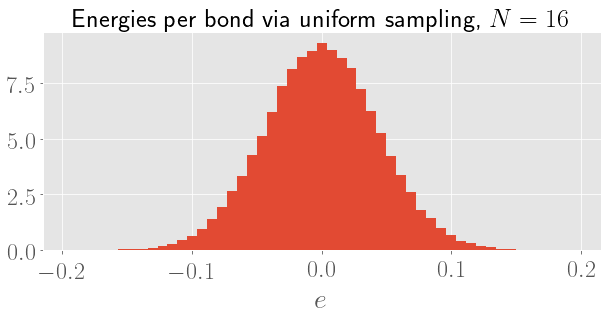

In [13]:
plt.hist(uniform_e_list, density = True, bins = 51)
plt.title('Energies per bond via uniform sampling, $N = 16$')
plt.xlabel(r'$e$')
## Uncomment the next line to save the plot
#plt.savefig('ex7_histogram_e_uniform.pdf', bbox_inches = 'tight')
plt.show()

Seems to be a Gaussian centered at 0, and is zero outside of -0.2 and 0.2.

## 7.2 - Hit and miss method

In [14]:
T1 = 10**5; T2 = 10**3; T3 = 10**2; T4 = 10
temperatures = [T1, T2, T3, T4]

Determine the fractions of saved hits. Number of runs can be changed below.

In [15]:
nreps = 10**3

In [16]:
fracs_N = {4 : [], 8 : [], 12 : [], 16 : []}
for key in fracs_N:
    
    fracs = []
    for T in temperatures:
        fracs_N[key].append(100*hit_and_miss_algorithm(key, T, nreps)[1]) # save as a percentage

In [17]:
df = pd.DataFrame.from_dict(fracs_N, orient = 'index', columns = ['T1', 'T2', 'T3', 'T4'])

In [18]:
df

,T1,T2,T3,T4
4,100.0,95.5,71.1,6.0
8,99.9,87.6,28.1,0.0
12,99.6,74.7,6.5,0.0
16,99.5,57.4,0.7,0.0


Uncomment the next line to export the LaTeX code to recreate this table in LaTeX.

In [19]:
#print(df.to_latex(index = True))  

## 7.3 Reweighting technique

To get the histogram via the reweighting technique, first get the uniform histogram. Use the total energy instead of the energies per bond.

In [20]:
N = 16
#T1 = 10**5; T2 = 10**3; T3 = 10; T4 = 2
#temperatures = [T1, T2, T3, T4]

We first need to do uniform sampling of the total energies. The following code block takes a bit of time.

In [21]:
nreps = 10**5
uniform_E_list = []

for i in range(nreps):
    uniform_E_list.append(ising_uniform_sampling(N, output = 'E')[-1]) # take [-1]: energy is added at the end

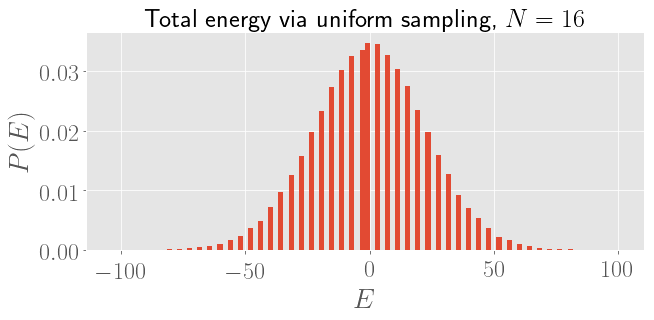

In [22]:
# Plot the uniform histogram
plt.hist(uniform_E_list, density = True, bins = 100)

# Make fancy, save and show
plt.title('Total energy via uniform sampling, $N = 16$')
plt.xlabel(r'$E$')
plt.ylabel(r'$P(E)$')
## Uncomment the next line to save the plot
#plt.savefig('ex7_uniform_total_energy.pdf', bbox_inches = 'tight')
plt.show()

$\textbf{Generate histograms for various temperatures}$

Warning: in the previous subsection of this notebook, we already defined the variable 'temperatures', but they are different. 

In [23]:
# Save the temperatures in a list:
temperatures = [10**5, 10**3, 10, 2]

weight_list = []
for t in temperatures:
    weight_list.append(get_weights(uniform_E_list, t))

Create four histograms using subplots.

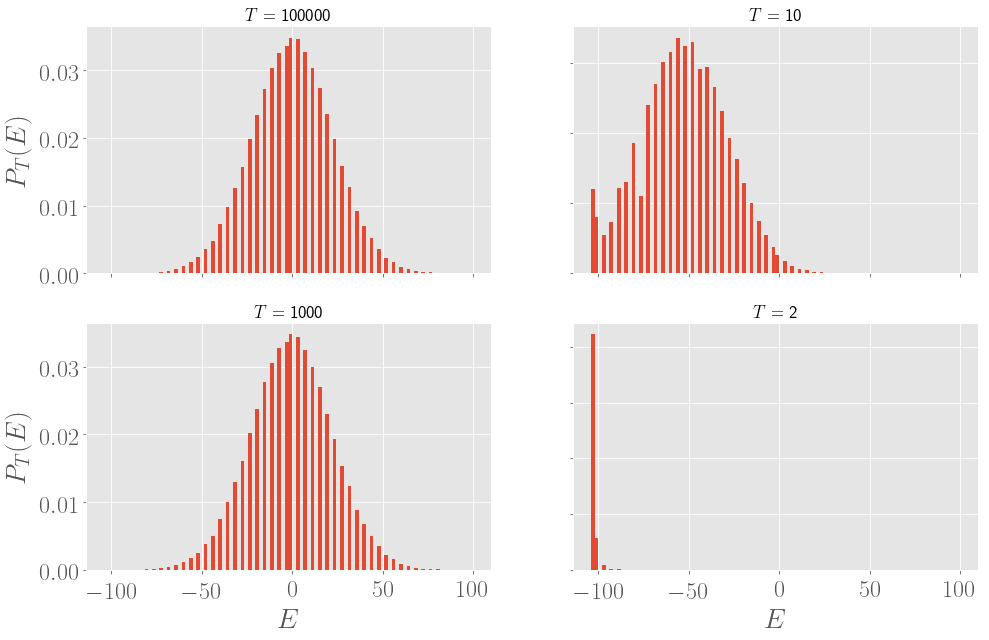

In [24]:
fig, axs = plt.subplots(2, 2, figsize = (16, 10))
bins_list = [100, 100, 100, 100] # play around with number of bins to get optimal results
for i in range(len(temperatures)):
    
    axs[i % 2, i // 2].hist(uniform_E_list, density = True, bins = bins_list[i], weights = weight_list[i])
    axs[i % 2, i // 2].set_title(r'$T = $ %d' % temperatures[i], size = 18)


# Make fancy, save and show
for ax in axs.flat:
    ax.set(ylabel = r'$P_T(E)$', xlabel = r'$E$')
    ax.label_outer()

# Uncomment the next line to save the plot
#plt.savefig('ex7_four_histograms_reweighting.pdf', bbox_inches = 'tight')
plt.show()